### Exploring prototypical distortions

This notebook contains code to demonstrate that generative networks such as VAEs make their outputs more prototypical.

Tested with tensorflow 2.11.0 and Python 3.10.9.

#### Installation

In [ ]:
!pip install -r requirements.txt
!pip install umap-learn

#### Imports

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
from distortions_utils import *
from tensorflow import keras
import numpy as np
from random import randrange
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.backends.backend_pdf
from config import dims_dict
from generative_model import models_dict
import matplotlib
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from umap import UMAP
from tensorflow.keras import layers
import tensorflow.keras.backend as K
from utils import display
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np

import warnings
warnings.filterwarnings("ignore")

# set tensorflow random seed to make outputs reproducible
tf.random.set_seed(123)
np.random.seed(123)

/Users/eleanorspens/Documents/PhD Code/algonauts/algovenv/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/eleanorspens/Documents/PhD Code/algonauts/algovenv/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/Users/eleanorspens/Docu

#### Measuring intra-class variation

Load MNIST VAE trained previously and some test data:

In [2]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
mnist_digits = np.concatenate([x_test], axis=0)
mnist_labels = np.concatenate([y_test], axis=0)
mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255

encoder, decoder = build_encoder_decoder_small(latent_dim=20)
encoder.load_weights("model_weights/mnist_encoder.h5")
decoder.load_weights("model_weights/mnist_decoder.h5")
vae = VAE(encoder, decoder, kl_weighting=1)

2023-08-15 08:19:50.314342: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-15 08:19:50.314758: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M2 Pro


Get latents and outputs before and after recall and optionally plot latent spaces:

In [33]:
test_data = mnist_digits
all_pixels = []
all_latents = []

latents = vae.encoder.predict(test_data)
latent_umap = UMAP(n_components=2, min_dist=1, n_neighbors=20)
latent_umap.fit(latents[0])
pixel_umap = UMAP(n_components=2, min_dist=1, n_neighbors=20)
pixel_umap.fit(test_data.reshape(test_data.shape[0], 784))

for i in range(2):    
    all_pixels.append(test_data)
    test_data, latents = check_generative_recall(vae, test_data, mnist_labels, latent_umap, pixel_umap, 
                                                 displaybool=False, n=3000)
    all_latents.append(latents)

313/313 [==============================] - 1s 2ms/step


Calculate the total variance across each MNIST class before and after recall:

In [4]:
variances = {}

for time_step in range(0,2):
    variances[time_step] = []
    for i in range(0,10):
        px = all_pixels[time_step][0:5000]
        inds = np.where((mnist_labels[0:5000]==i))
        px_for_digit = px[inds]

        # Reshape the images into 1D vectors (n, 784)
        reshaped_images = px_for_digit.reshape((px_for_digit.shape[0], -1))
        # Calculate variance per pixel of images, giving array of shape (784,), then average
        mean_variance = np.mean(np.var(reshaped_images, axis=0))
        variances[time_step].append(mean_variance)

Plot intra-class variation before and after recall for each MNIST class:

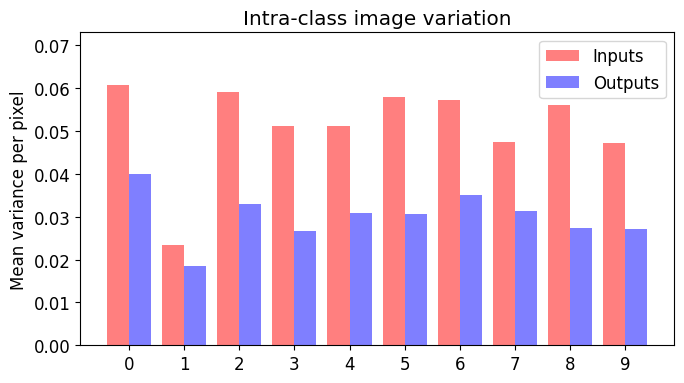

In [5]:
matplotlib.rcParams.update({'font.size': 12})

labels = range(10)
before_means = variances[0]
after_means = variances[1]

x = np.arange(len(labels))
width = 0.4 

fig, ax = plt.subplots(figsize=(7,4))
rects1 = ax.bar(x - width/2, before_means, width, label='Inputs', color='red', alpha=0.5)
rects2 = ax.bar(x + width/2, after_means, width, label='Outputs', color='blue', alpha=0.5)

ax.set_ylabel('Mean variance per pixel')
ax.set_title('Intra-class image variation')
plt.xticks(x)
plt.ylim(0, 0.073)
ax.legend()

fig.tight_layout()
plt.show()